<a href="https://colab.research.google.com/github/kianahs/Machine-Learning/blob/main/wk3_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday, 27th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [237]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [238]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
# sn.pairplot(diabetes_db)

In [239]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [240]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [241]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  ### your code here
  z = (x - mu) / sigma
  return z

###your code here
x_train_mean = x_train.mean(dim=0)
x_train_std =  x_train.std(dim=0)
x_train = norm_set(x_train, x_train_mean , x_train_std)
x_test = norm_set(x_test, x_train_mean, x_train_std)

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [242]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    y = torch.matmul(x, self.weight.t())
    return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [243]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [244]:
x_train

tensor([[ 1.4962,  1.0599,  0.2196,  ...,  0.5467, -0.0614,  1.0000],
        [-0.2285,  1.0599, -0.4188,  ..., -0.0197,  0.3667,  1.0000],
        [ 0.0851, -0.9408,  1.0175,  ...,  0.3308, -0.3182,  1.0000],
        ...,
        [ 0.6339, -0.9408, -0.4644,  ..., -0.2534, -0.0614,  1.0000],
        [-0.3069, -0.9408, -0.5328,  ..., -0.8295, -0.8319,  1.0000],
        [-2.0317, -0.9408,  0.5616,  ..., -0.1329, -0.0614,  1.0000]])

In [245]:
## test the custom layer
# print(x_train.shape[1])
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1
# print(prediction)

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [246]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  ### your code here
  return torch.sum(torch.pow((y_pred - y_true), 2)) / y_pred.numel()

In [247]:
cost = mean_squared_error(prediction, y_train)
print(cost)

tensor(29711.3223)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [248]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  # calculate the partial derivative of the loss function with respect to w
  partial_derivative = 2 * torch.matmul(X.t(), (y_pred-y)) / N
  # calculate the new values the weights
  weight -= lr * partial_derivative.t()
  model.weight = nn.Parameter(weight, requires_grad=False)


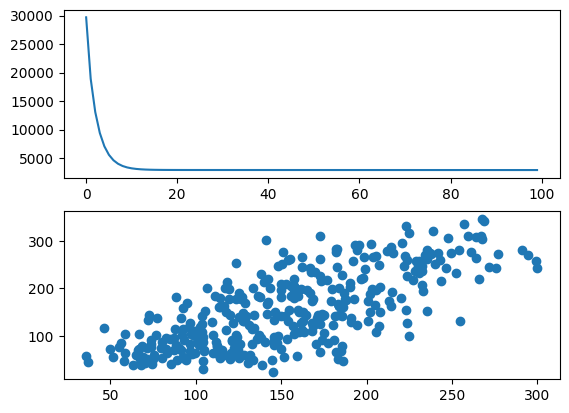

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum cost: 2890.406494140625


In [249]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [250]:
model.weight[0,1], model.weight[0,2]

(tensor(-11.4488), tensor(26.3047))

<font color="yellow">In linear regression, the weight values, also known as coefficients or regression coefficients, represent the importance or influence of each predictor variable on the target variable. The sign (positive or negative) of the weight value indicates the direction of the relationship, while the magnitude represents the strength of the relationship.
By examining the weight values, you can make the following conclusions:

Positive weight values for a predictor variable indicate that an increase in that variable is associated with an increase in blood sugar levels, while negative weight values indicate the opposite.
The magnitude of the weight value determines the extent of the influence. A larger magnitude suggests a stronger relationship between the predictor and the target variable.</font>
<font color="yellow">
Gender: If the weight value for gender is statistically significant and has a non-zero value, it suggests that gender has an influence on blood sugar levels. For example, if the weight value for gender is positive, it indicates that being of a certain gender (e.g., male or female) is associated with higher blood sugar levels, while a negative weight suggests the opposite. The magnitude of the weight value provides an indication of the strength of this association.
BMI: Similarly, if the weight value for BMI is statistically significant and non-zero, it implies that BMI has an impact on blood sugar levels. A positive weight value for BMI suggests that higher BMI values are associated with higher blood sugar levels, while a negative weight value indicates the opposite. The magnitude of the weight value determines the strength of this relationship.</font>

In [251]:
import numpy as np
### your code here
sample_data = np.array([[25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68 ],
          [50,	1, 28,	103,	229,	162.2,	60,	4.5,	6.107, 124]])

sample_data_tensor = torch.from_numpy(sample_data).float()
sample_data_tensor = norm_set(sample_data_tensor, x_train_mean, x_train_std)
sample_data_tensor = torch.cat([sample_data_tensor, torch.ones(sample_data_tensor.shape[0], 1)], dim=1)
prediction = model(sample_data_tensor)
prediction

tensor([[ 43.5294],
        [232.2310]])

Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [252]:
### your code here
test_prediction = model(x_test)
cost = mean_squared_error(test_prediction, y_test)
print(cost)

tensor(2885.6191)


<font color="Yellow"> Comparison of errors: the mean squared error (MSE) on the train set is tensor(29711.3223), while the MSE on the test set is tensor(2929.9829). It appears that the MSE on the test set is significantly lower than that on the train set. This suggests that the model is performing better on the test set compared to the train set, which is generally desirable. However, the absolute values of the errors alone do not provide a complete understanding of the model's performance. It is important to consider the scale and context of the problem to make a meaningful comparison.</font>


<font color="Yellow">Model fit: The fit of the model refers to how well it captures the underlying patterns and relationships in the data. A well-fitting model should generalize well to unseen data, such as the test set. In your case, if the model is performing better on the test set than the train set, it suggests that the model has learned the patterns in the data and is generalizing well.</font>


<font color="Yellow">Overfitting: Overfitting occurs when a model learns the training data too well, to the extent that it captures noise or random fluctuations in the data. This results in poor performance on unseen data, such as the test set. Signs of overfitting include a significantly lower error on the train set compared to the test set. To mitigate overfitting, techniques like regularization, cross-validation, or reducing model complexity can be employed.</font>


<font color="Yellow">Underfitting: Underfitting, on the other hand, occurs when a model is too simplistic or has insufficient capacity to capture the underlying patterns in the data. This leads to poor performance on both the train and test sets. Signs of underfitting include high errors on both sets and a lack of improvement as the model complexity increases. In such cases, it may be necessary to increase the model's capacity or consider more advanced models.</font>


<font color="Yellow">In summary, based on the provided information, it seems that the model is performing better on the test set compared to the train set, indicating a good fit. However, it is important to consider the specific problem, data, and context to make a more comprehensive evaluation of the model's performance.</font>


<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

In [253]:
def calculate_error(lr):

  cost_lst = list()
  model = LinearRegression(x_train.shape[1])

  for it in range(100):
    prediction = model(x_train)
    cost = mean_squared_error(y_train, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x_train, y_train, prediction, lr)

  test_prediction = model(x_test)
  test_cost = mean_squared_error(y_test, test_prediction)
  print("Learning_rate {}\n Min_train_cost {}\n test_cost {}\n--------\n".format(lr, min(cost_lst), test_cost ))
  return min(cost_lst), test_cost

In [254]:
### your code here
learning_rates = np.arange(0.01, 0.2 + 0.01, 0.01)
train_costs = []
test_costs = []
for lr in learning_rates:
  min_train_cost, test_cost = calculate_error(lr)
  test_costs.append(test_cost)
  train_costs.append(min_train_cost)



Learning_rate 0.01
 Min_train_cost 3356.77734375
 test_cost 3431.068359375
--------

Learning_rate 0.02
 Min_train_cost 2906.434814453125
 test_cost 2906.97900390625
--------

Learning_rate 0.03
 Min_train_cost 2897.025634765625
 test_cost 2885.867431640625
--------

Learning_rate 0.04
 Min_train_cost 2895.79345703125
 test_cost 2884.759521484375
--------

Learning_rate 0.05
 Min_train_cost 2894.800048828125
 test_cost 2884.92236328125
--------

Learning_rate 0.060000000000000005
 Min_train_cost 2893.853515625
 test_cost 2885.09912109375
--------

Learning_rate 0.06999999999999999
 Min_train_cost 2892.943115234375
 test_cost 2885.2470703125
--------

Learning_rate 0.08
 Min_train_cost 2892.066162109375
 test_cost 2885.381591796875
--------

Learning_rate 0.09
 Min_train_cost 2891.220703125
 test_cost 2885.5048828125
--------

Learning_rate 0.09999999999999999
 Min_train_cost 2890.406494140625
 test_cost 2885.619140625
--------

Learning_rate 0.11
 Min_train_cost 2889.62109375
 test_cos

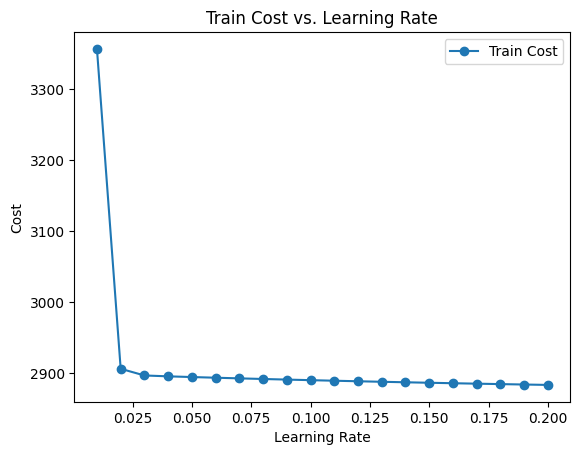

In [255]:
plt.plot(learning_rates, train_costs, marker='o', label='Train Cost')

plt.xlabel('Learning Rate')
plt.ylabel('Cost')
plt.title('Train Cost vs. Learning Rate')
plt.legend()
plt.show()

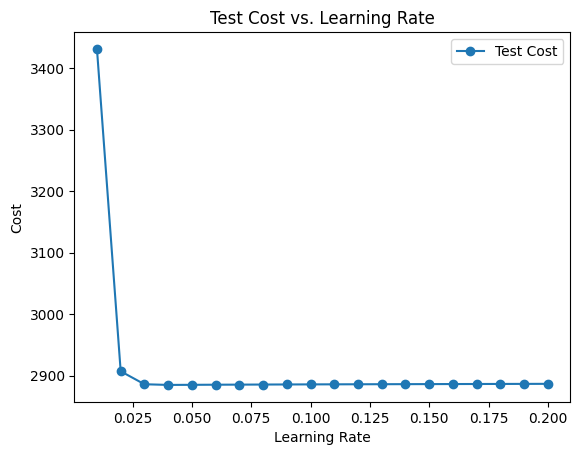

In [256]:

plt.plot(learning_rates, test_costs, marker='o', label='Test Cost')


plt.xlabel('Learning Rate')
plt.ylabel('Cost')
plt.title('Test Cost vs. Learning Rate')
plt.legend()
plt.show()

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

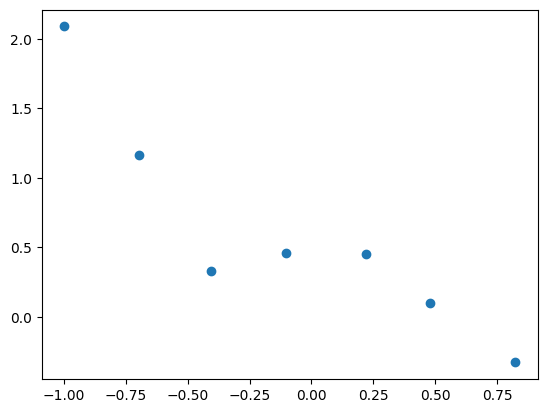

In [257]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

Adjust variable `x` to include the higher order polynomials

In [258]:
### your code here
### hint: remember to add x_0 for the bias
x3 = torch.stack([torch.ones_like(x), x**1, x**2, x**3, x**4, x**5 ], dim=1)
print(x3)

tensor([[ 1.0000e+00, -9.9768e-01,  9.9537e-01, -9.9306e-01,  9.9075e-01,
         -9.8845e-01],
        [ 1.0000e+00, -6.9574e-01,  4.8405e-01, -3.3678e-01,  2.3431e-01,
         -1.6302e-01],
        [ 1.0000e+00, -4.0373e-01,  1.6300e-01, -6.5807e-02,  2.6568e-02,
         -1.0726e-02],
        [ 1.0000e+00, -1.0236e-01,  1.0478e-02, -1.0725e-03,  1.0978e-04,
         -1.1237e-05],
        [ 1.0000e+00,  2.2024e-01,  4.8506e-02,  1.0683e-02,  2.3528e-03,
          5.1818e-04],
        [ 1.0000e+00,  4.7742e-01,  2.2793e-01,  1.0882e-01,  5.1952e-02,
          2.4803e-02],
        [ 1.0000e+00,  8.2229e-01,  6.7616e-01,  5.5600e-01,  4.5719e-01,
          3.7595e-01]])


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [259]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
  ### your code here
  m = y_true.shape[0]
  return (torch.sum((y_pred - y_true) ** 2) / (2*m)) + ((lam / (2 * m)) * torch.sum(theta ** 2))

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  weight[0, 0] = weight[0,0] - ((lr/ N) * torch.sum((y_pred - y).t() * X[:,0]))
  weight[0, 1:] = (weight[0, 1:] * (1 - (lr * lam / N))) - ((lr/ N) * torch.matmul((y_pred - y).t(),  X[:, 1:]))
  model.weight = nn.Parameter(weight, requires_grad=False)

<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

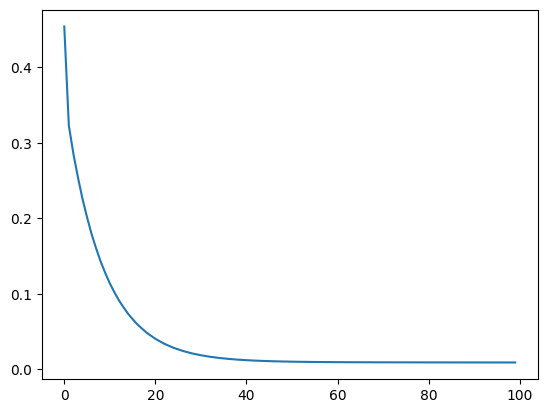

Parameter containing:
tensor([[ 0.3796, -0.2814,  0.0965, -0.8095,  0.1385, -0.4215]])
Minimum cost: 0.008910697884857655


In [260]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 1.42 # select an appropriate alpha
lam = 0.01 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))


In [261]:
#FINDING ALPHA
# alphas = np.arange(0.01, 10 + 0.01, 0.01) # select an appropriate alpha
# lam = 0 # select an appropriate lambda
# total_costs = []
# for alpha in alphas:
#   cost_lst = list()
#   model = LinearRegression(x3.shape[1])
#   for it in range(100):
#     prediction = model(x3)
#     cost = mean_squared_error(y, prediction, lam, model.weight)
#     cost_lst.append(cost)
#     gradient_descent_step(model, x3, y, prediction, alpha, lam)

#   display.clear_output(wait=True)
#   total_costs.append(min(cost_lst))

# plt.plot(alphas, total_costs)
# plt.show()
# # print(model.weight)
# print('Minimum cost: {} alpha: {}'.format(min(total_costs), alphas[total_costs.index(min(total_costs))]))


In [262]:
#FINDING LAMBDA BASED ON ALPHA
# alpha = 1.42 # select an appropriate alpha
# lambdas = np.arange(0.01, 10 + 0.01, 0.01) # select an appropriate lambda
# total_costs = []
# for lam in lambdas:
#   cost_lst = list()
#   model = LinearRegression(x3.shape[1])
#   for it in range(100):
#     prediction = model(x3)
#     cost = mean_squared_error(y, prediction, lam, model.weight)
#     cost_lst.append(cost)
#     gradient_descent_step(model, x3, y, prediction, alpha, lam)

#   display.clear_output(wait=True)
#   total_costs.append(min(cost_lst))

# plt.plot(lambdas, total_costs)
# plt.show()
# # print(model.weight)
# print('Minimum cost: {} lambda: {}'.format(min(total_costs), lambdas[total_costs.index(min(total_costs))]))

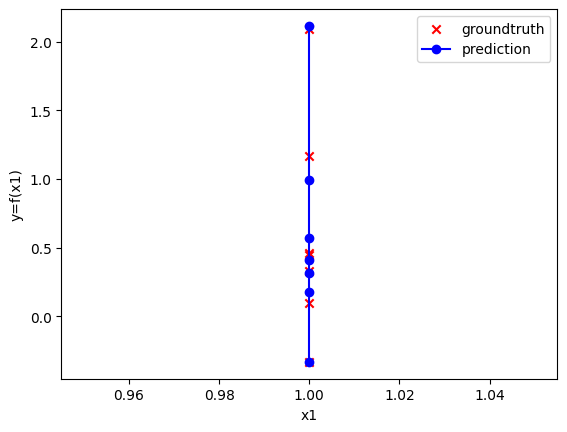

In [263]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

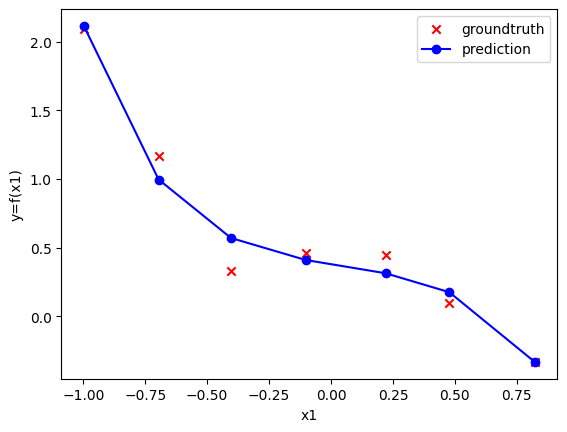

In [264]:
plt.scatter(x3[:, 1], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()